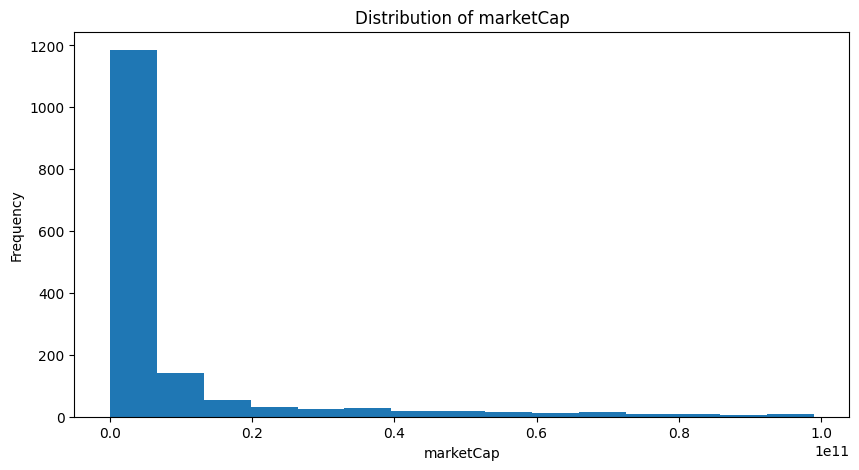

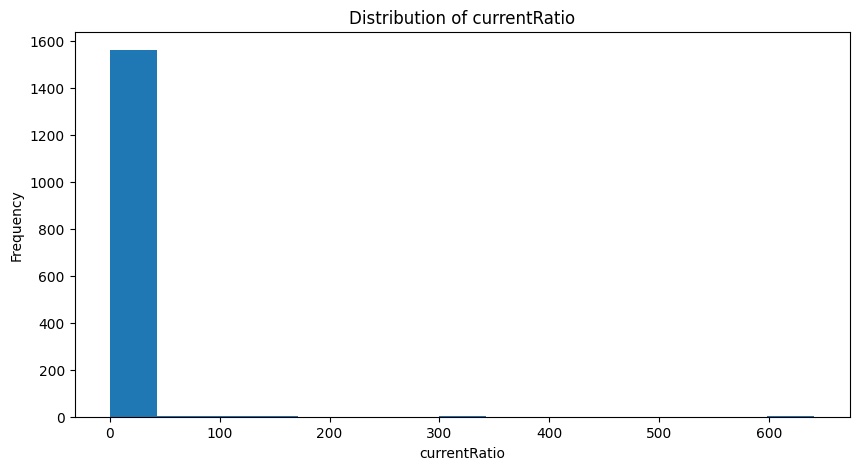

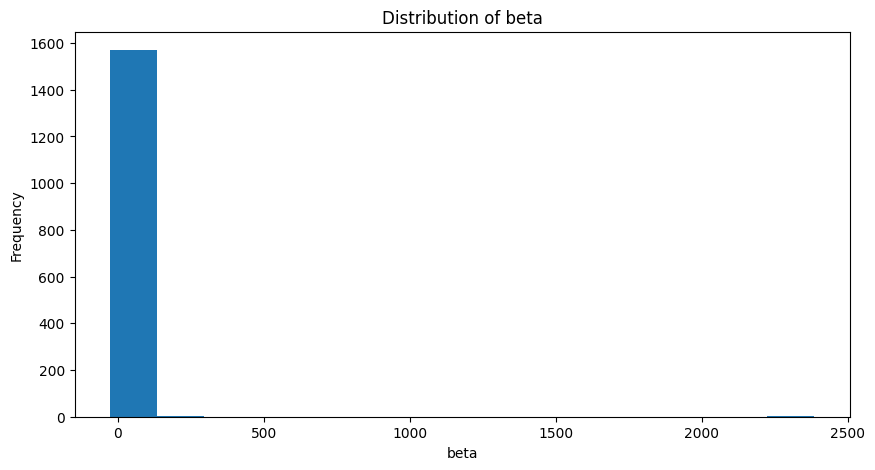

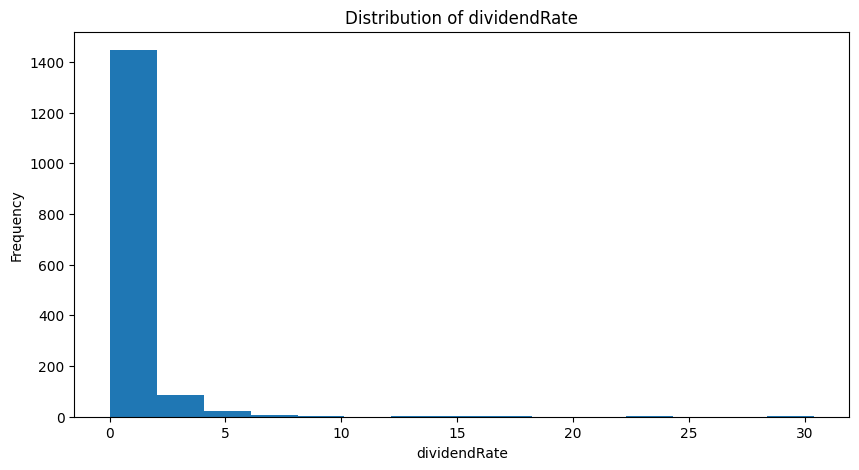

In [114]:
import pandas as pd
import matplotlib.pyplot as plt

# Replace 'your_data.csv' with the path to your cleaned data file
df = pd.read_csv('/content/data_final2.csv', delimiter=';')

# Clean up the column names
df.columns = df.columns.str.strip()

# Convert 'marketCap' to a numerical format if it's not already
df['marketCap'] = pd.to_numeric(df['marketCap'].str.replace('[Ee\+]', 'e', regex=True), errors='coerce')

# Drop rows with any missing values
df_cleaned = df.dropna()

# Plot histograms for numerical features
numerical_columns = ['marketCap', 'currentRatio', 'beta', 'dividendRate']
for column in numerical_columns:
    plt.figure(figsize=(10, 5))
    df_cleaned[column].hist(bins=15)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.grid(False)
    plt.show()


In [115]:
# Summary Statistics
summary_stats = df.describe()
# Correlation Matrix
#correlation_matrix = df.corr()


In [116]:
# Assuming 'symbol' is a non-numeric column, which we don't want in our correlation matrix
# Let's first remove any non-relevant columns for correlation, such as 'symbol' and 'shortName'
df_numeric = df.drop(['symbol', 'shortName', 'sector', 'country'], axis=1)

# Now, ensure all remaining columns are numeric
for col in df_numeric.columns:
    df_numeric[col] = pd.to_numeric(df_numeric[col], errors='coerce')

# Drop any rows that now contain NaNs after the conversion
df_numeric = df_numeric.dropna()

# Now you should be able to calculate the correlation matrix without errors
correlation_matrix = df_numeric.corr()

# Display the correlation matrix
print(correlation_matrix)


              marketCap  currentRatio      beta  dividendRate
marketCap      1.000000     -0.046299 -0.017674      0.269012
currentRatio  -0.046299      1.000000 -0.006067     -0.030286
beta          -0.017674     -0.006067  1.000000     -0.015378
dividendRate   0.269012     -0.030286 -0.015378      1.000000


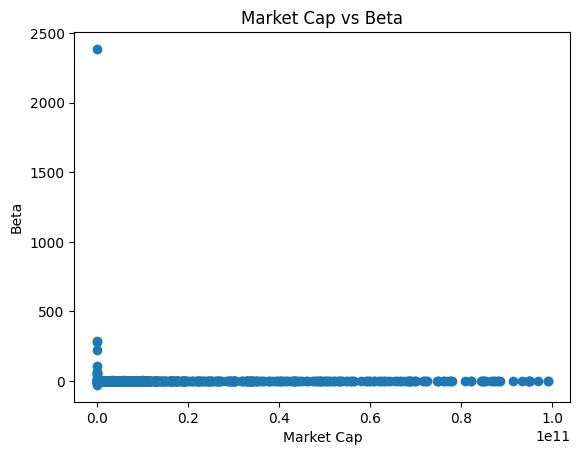

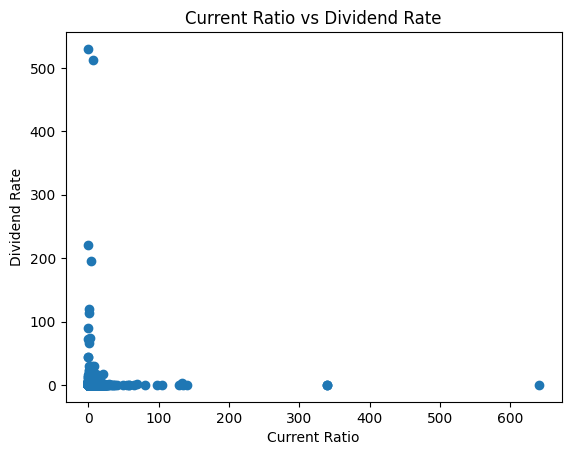

In [117]:
# Scatter Plot between Market Cap and Beta
plt.scatter(df['marketCap'], df['beta'])
plt.title('Market Cap vs Beta')
plt.xlabel('Market Cap')
plt.ylabel('Beta')
plt.show()

# Scatter Plot between Current Ratio and Dividend Rate
plt.scatter(df['currentRatio'], df['dividendRate'])
plt.title('Current Ratio vs Dividend Rate')
plt.xlabel('Current Ratio')
plt.ylabel('Dividend Rate')
plt.show()


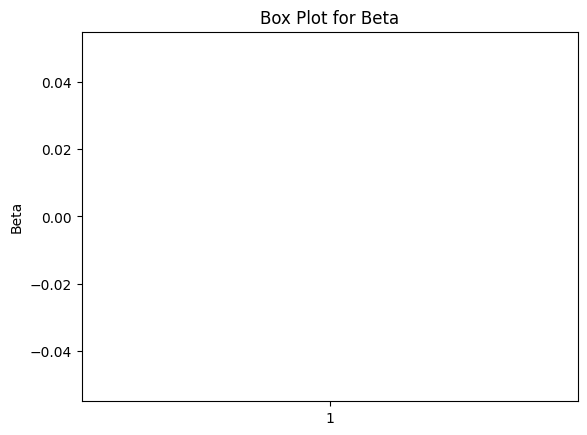

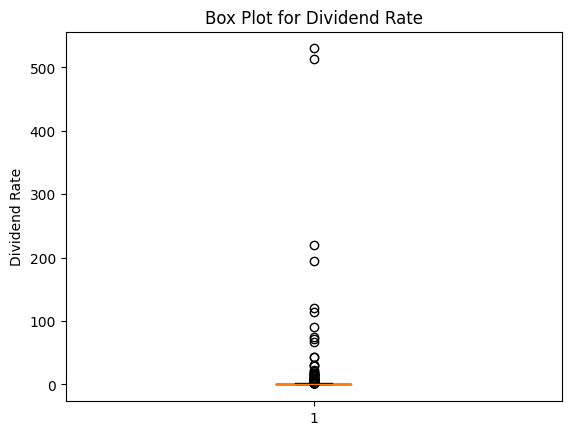

In [118]:
# Box Plot for Beta
plt.boxplot(df['beta'])
plt.title('Box Plot for Beta')
plt.ylabel('Beta')
plt.show()

# Box Plot for Dividend Rate
plt.boxplot(df['dividendRate'])
plt.title('Box Plot for Dividend Rate')
plt.ylabel('Dividend Rate')
plt.show()


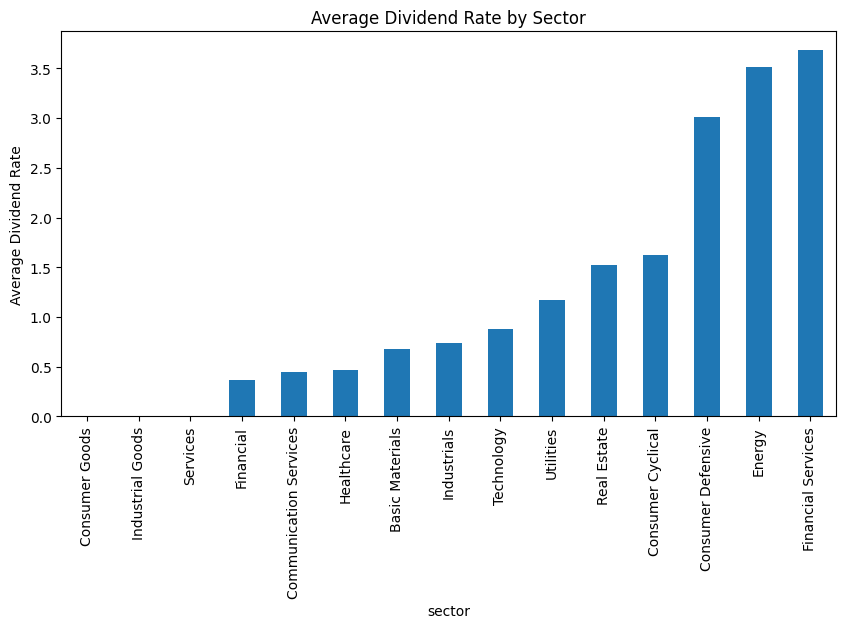

In [119]:
# Grouped bar plot for average dividend rate by sector
sector_group = df.groupby('sector')['dividendRate'].mean().sort_values()
sector_group.plot(kind='bar', figsize=(10, 5))
plt.title('Average Dividend Rate by Sector')
plt.ylabel('Average Dividend Rate')
plt.show()


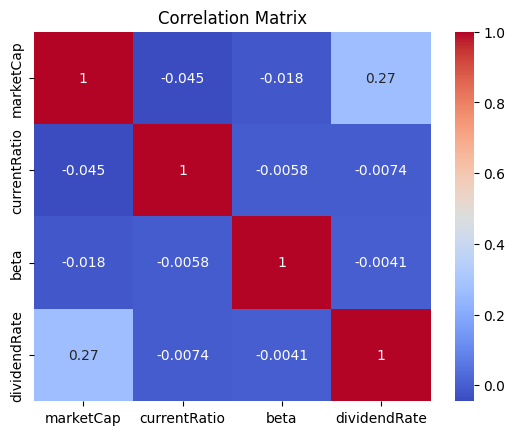

In [120]:
# Calculate and visualize the correlation matrix
import seaborn as sns

correlation_matrix = df[['marketCap', 'currentRatio', 'beta', 'dividendRate']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


In [121]:
from sklearn.ensemble import RandomForestRegressor

# Update the pipeline to use a regressor instead of a classifier
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

# Fit the pipeline
pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pipeline.predict(X_test)

# Optionally evaluate with a regression metric, like mean squared error
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)


Mean Squared Error: 190.02999665940374


In [126]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier

# Define imputers for numeric and categorical data
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Fill missing values with median for numeric columns
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),  # Fill missing values with a constant for categorical columns
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])  # Encode categorical variables

# Assume you have lists of numeric and categorical columns
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = ['sector', 'country']  # adjust this according to your actual dataset

# Combine into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create the complete pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Fit the pipeline with categorical target data
pipeline.fit(X_train, y_train_categorical)

# Now predict and evaluate the model
y_pred = pipeline.predict(X_test)  # Assume you have processed y_test similarly


Confusion Matrix:
 [[166  45]
 [ 31 113]]
Accuracy: 0.7859154929577464


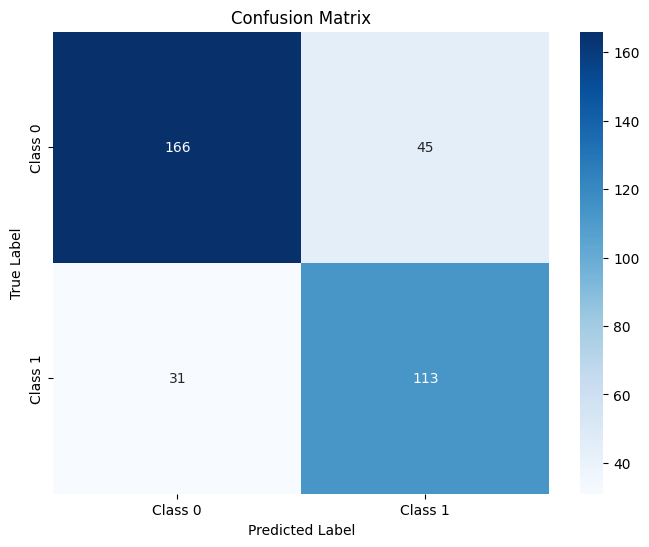

In [127]:
from sklearn.metrics import confusion_matrix, accuracy_score

# Evaluate the model
cm = confusion_matrix(y_test_categorical, y_pred)
accuracy = accuracy_score(y_test_categorical, y_pred)

# Print the confusion matrix and accuracy
print("Confusion Matrix:\n", cm)
print("Accuracy:", accuracy)

# If you want to plot the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


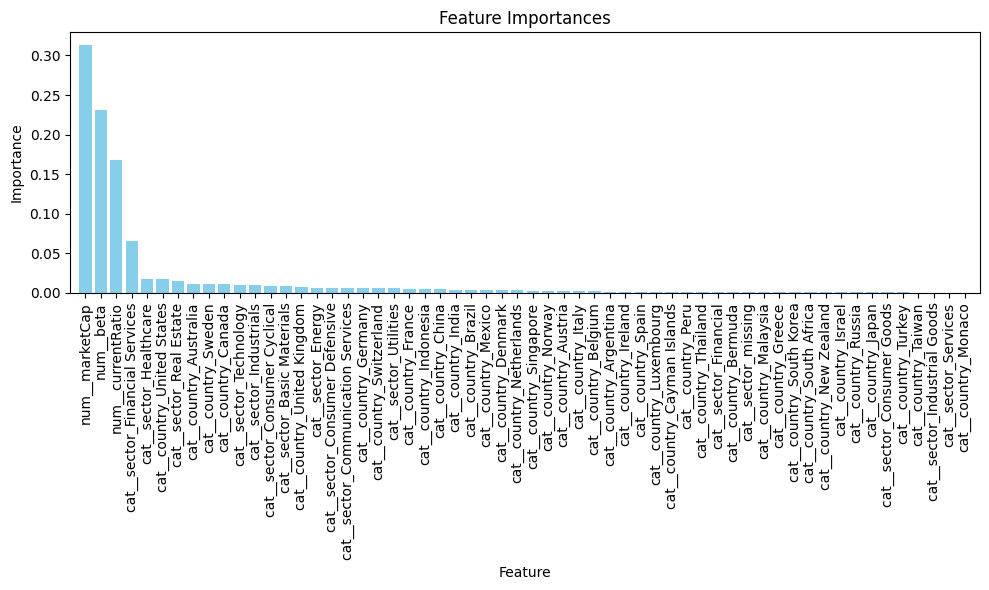

In [129]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'pipeline' is your fitted pipeline which includes preprocessing and the classifier
# Extract the classifier from the pipeline
model = pipeline.named_steps['classifier']

# Check if your preprocessor uses ColumnTransformer and extract feature names
if 'preprocessor' in pipeline.named_steps:
    preprocessor = pipeline.named_steps['preprocessor']
    if hasattr(preprocessor, 'get_feature_names_out'):
        # For newer versions of scikit-learn
        feature_names = preprocessor.get_feature_names_out()
    else:
        # Manual feature names handling for older versions of scikit-learn or custom feature names handling
        feature_names = []
        for name, transformer, column in preprocessor.transformers_[:-1]:  # The last one is usually 'remainder'
            if isinstance(transformer, Pipeline):
                # If pipeline, get the last transformer
                transformer = transformer.steps[-1][1]
            if hasattr(transformer, 'get_feature_names'):
                feature_names.extend(transformer.get_feature_names(column))
            else:
                feature_names.extend(column)
else:
    feature_names = X_train.columns  # Fallback if no complex preprocessing

# Get feature importances from the model
importances = model.feature_importances_

# Sort the feature importances in descending order and get the indices
indices = np.argsort(importances)[::-1]

# Plotting
plt.figure(figsize=(10, 6))
plt.title('Feature Importances')
plt.bar(range(len(importances)), importances[indices], align='center', color='skyblue')
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
plt.xlim([-1, len(importances)])
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.tight_layout()  # Adjust layout to make room for rotated x-axis labels
plt.show()


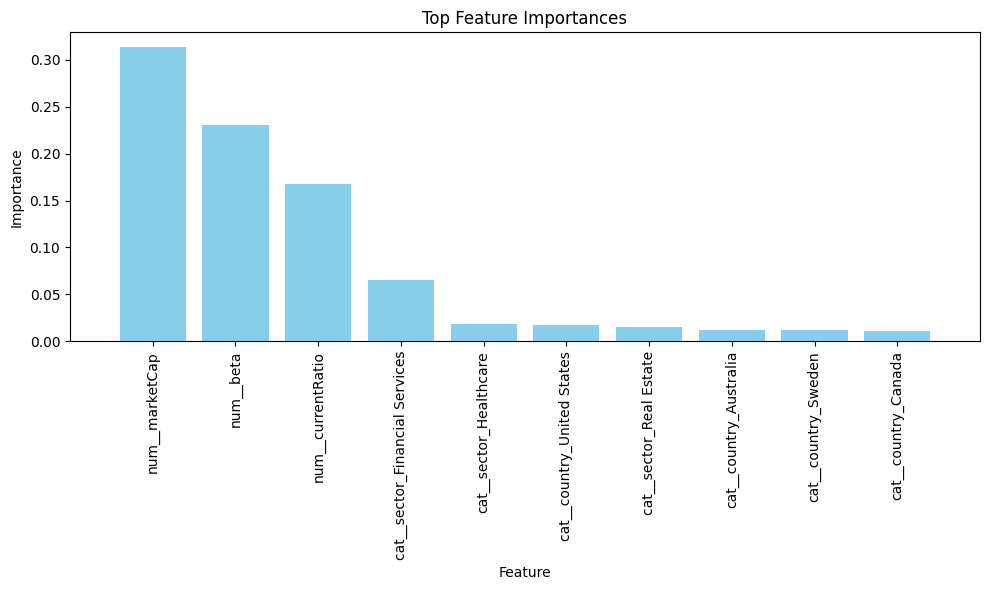

In [131]:
import numpy as np
import matplotlib.pyplot as plt

# Extract the classifier and feature names as previously described
model = pipeline.named_steps['classifier']
if 'preprocessor' in pipeline.named_steps:
    preprocessor = pipeline.named_steps['preprocessor']
    feature_names = preprocessor.get_feature_names_out()

# Get feature importances from the model
importances = model.feature_importances_

# Filter out features related to 'country'
filtered_indices = [i for i, name in enumerate(feature_names) if not name.startswith('cat_country')]
filtered_importances = importances[filtered_indices]
filtered_feature_names = [feature_names[i] for i in filtered_indices]

# Sort the filtered feature importances in descending order and get the indices
indices = np.argsort(filtered_importances)[::-1]

# Optionally, limit to top N features for clarity
top_n = 10
top_indices = indices[:top_n]

# Plotting
plt.figure(figsize=(10, 6))
plt.title('Top Feature Importances')
plt.bar(range(len(top_indices)), filtered_importances[top_indices], align='center', color='skyblue')
plt.xticks(range(len(top_indices)), [filtered_feature_names[i] for i in top_indices], rotation=90)
plt.xlim([-1, len(top_indices)])
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.tight_layout()  # Adjust layout to make room for rotated x-axis labels
plt.show()


In [136]:
# Define a threshold for categorization
threshold = 0.5  # This is arbitrary; adjust based on your specific use case

# Convert continuous targets to binary categories (0 or 1)
y_train_categorical = (y_train > threshold).astype(int)
y_test_categorical = (y_test > threshold).astype(int)

# Fit the model with the categorical target
clf.fit(X_train, y_train_categorical)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['marketCap', 'currentRatio',
                                                   'beta']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['sector', 'country'])])),
                ('classifier', RandomForestClassifier(random_state=42))])

In [137]:
from sklearn.ensemble import RandomForestRegressor

# Update the pipeline to use a regressor
clf = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

# Fit the regression model
clf.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['marketCap', 'currentRatio',
                                                   'beta']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['sector', 'country'])])),
                ('regressor', RandomForestRegressor(random_state=42))])

In [138]:
from sklearn.metrics import mean_squared_error

# Predict and calculate MSE
y_pred = clf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)


Mean Squared Error: 190.02999665940374


In [139]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__max_depth': [None, 10, 20, 30],
    'regressor__min_samples_split': [2, 5, 10]
}
grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(-grid_search.best_score_))


Best parameters: {'regressor__max_depth': 10, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 100}
Best cross-validation score: 368.75


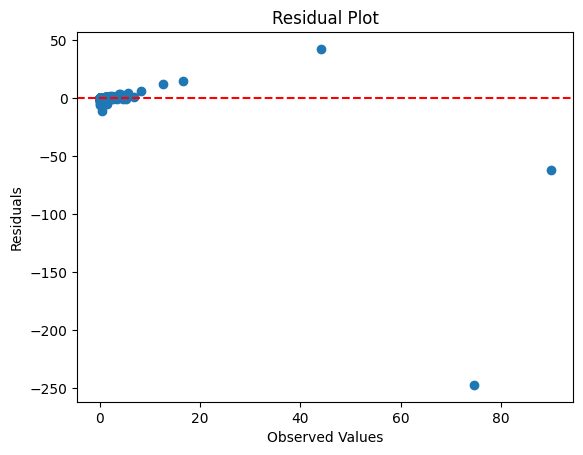

In [140]:
residuals = y_test - y_pred
plt.scatter(y_test, residuals)
plt.title('Residual Plot')
plt.xlabel('Observed Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()


In [142]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    scores = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred, average='binary'),
        "Precision": precision_score(y_test, y_pred, average='binary'),
        "F1-Score": f1_score(y_test, y_pred, average='binary')
    }
    return scores


In [143]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import xgboost as xgb

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize models
dt_model = DecisionTreeClassifier(random_state=42)
rf_model = RandomForestClassifier(max_depth=10, min_samples_split=2, n_estimators=100, random_state=42)
xgb_model = xgb.XGBClassifier(random_state=42)

models = {
    "Decision Trees": dt_model,
    "Random Forest": rf_model,
    "XGBoost": xgb_model
}


In [145]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# Define the categorical and numerical features (update these lists according to your dataset)
numeric_features = ['marketCap', 'currentRatio', 'beta']  # Assuming these are the numerical columns
categorical_features = ['sector', 'country']  # Assuming these are the categorical columns

# Create preprocessing steps
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Handles missing values
    ('scaler', StandardScaler())])  # Standardizes the numerical features

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),  # Handles missing values
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])  # One-hot encodes categorical features

# Combine preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Update your model pipeline setup
from sklearn.ensemble import RandomForestClassifier

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Assuming you've correctly defined X and y (check that y is appropriate for classification)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [147]:
from sklearn.ensemble import RandomForestRegressor

# Update your pipeline to use a regressor instead of a classifier
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

# Fit the regression model
pipeline.fit(X_train, y_train)

# You can evaluate with regression metrics such as Mean Squared Error (MSE)
from sklearn.metrics import mean_squared_error

y_pred = pipeline.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)


Mean Squared Error: 190.02999665940374


In [151]:
# Example threshold to categorize continuous data to binary
threshold = 0.5  # Adjust based on your dataset specifics

# Converting to binary categorical data
y_train_categorical = (y_train > threshold).astype(int)
y_test_categorical = (y_test > threshold).astype(int)

# Fitting the model
pipeline.fit(X_train, y_train_categorical)

# Predicting the test set
y_pred = pipeline.predict(X_test)

# Ensure that y_pred are indeed binary (0 or 1)
y_pred = (y_pred > threshold).astype(int)  # This line is usually not necessary but added here for troubleshooting

# Evaluate the classification accuracy
from sklearn.metrics import accuracy_score
print("Accuracy:", accuracy_score(y_test_categorical, y_pred))


Accuracy: 0.7746478873239436


In [158]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

# Preprocessing pipeline
numeric_features = ['marketCap', 'currentRatio', 'beta']
categorical_features = ['sector', 'country']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Define regression models
decision_tree_model = Pipeline(steps=[('preprocessor', preprocessor),
                                      ('regressor', DecisionTreeRegressor())])

random_forest_model = Pipeline(steps=[('preprocessor', preprocessor),
                                      ('regressor', RandomForestRegressor())])

xgboost_model = Pipeline(steps=[('preprocessor', preprocessor),
                                ('regressor', XGBRegressor())])

# Train your regression models
decision_tree_model.fit(X_train, y_train)
random_forest_model.fit(X_train, y_train)
xgboost_model.fit(X_train, y_train)

# Make predictions
dt_y_pred = decision_tree_model.predict(X_test)
rf_y_pred = random_forest_model.predict(X_test)
xgb_y_pred = xgboost_model.predict(X_test)

# Calculate Mean Squared Error (MSE)
dt_mse = mean_squared_error(y_test, dt_y_pred)
rf_mse = mean_squared_error(y_test, rf_y_pred)
xgb_mse = mean_squared_error(y_test, xgb_y_pred)

# Print the MSE for each model
print("Model\t\tMSE")
print(f"Decision Trees\t{dt_mse:.2f}")
print(f"Random Forest\t{rf_mse:.2f}")
print(f"XGBoost\t\t{xgb_mse:.2f}")


Model		MSE
Decision Trees	643.83
Random Forest	249.02
XGBoost		601.40


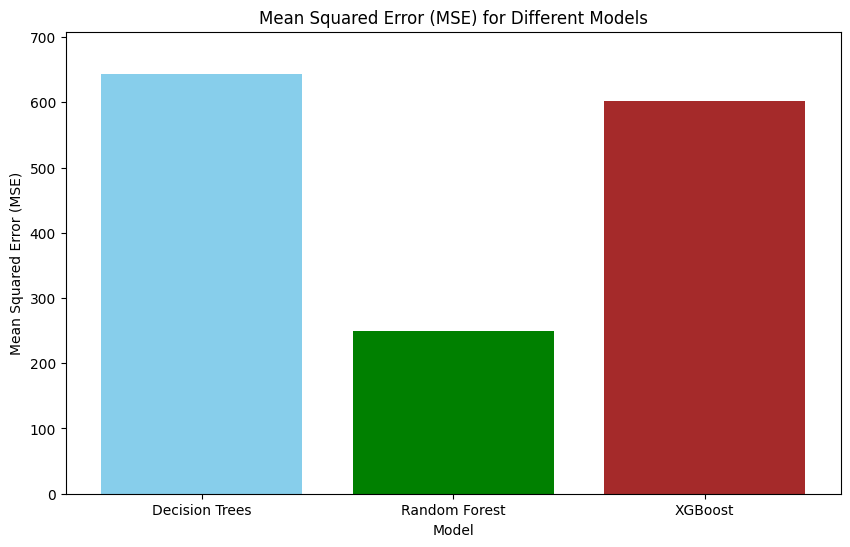

In [164]:
import matplotlib.pyplot as plt

# Model names
models = ['Decision Trees', 'Random Forest', 'XGBoost']

# Mean Squared Error (MSE) values
mse_values = [643.83, 249.02, 601.40]

# Create bar plot
plt.figure(figsize=(10, 6))
plt.bar(models, mse_values, color=['skyblue', 'green', 'brown'])
plt.xlabel('Model')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Mean Squared Error (MSE) for Different Models')
plt.ylim(0, max(mse_values) * 1.1)  # Adjust the y-axis limit for better visualization
plt.show()


In [169]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calculate Mean Squared Error (MSE)
dt_mse = mean_squared_error(y_test, dt_y_pred)
rf_mse = mean_squared_error(y_test, rf_y_pred)
xgb_mse = mean_squared_error(y_test, xgb_y_pred)

# Calculate Mean Absolute Error (MAE)
dt_mae = mean_absolute_error(y_test, dt_y_pred)
rf_mae = mean_absolute_error(y_test, rf_y_pred)
xgb_mae = mean_absolute_error(y_test, xgb_y_pred)

# Calculate R-squared (R2) score
dt_r2 = r2_score(y_test, dt_y_pred)
rf_r2 = r2_score(y_test, rf_y_pred)
xgb_r2 = r2_score(y_test, xgb_y_pred)

# Print the evaluation metrics for each model
print("Model\t\tMSE\t\tMAE\t\tR2 Score")
print(f"Decision Trees\t{dt_mse:.2f}\t\t{dt_mae:.2f}\t\t{dt_r2:.2f}")
print(f"Random Forest\t{rf_mse:.2f}\t\t{rf_mae:.2f}\t\t{rf_r2:.2f}")
print(f"XGBoost\t\t{xgb_mse:.2f}\t\t{xgb_mae:.2f}\t\t{xgb_r2:.2f}")


Model		MSE		MAE		R2 Score
Decision Trees	644.11		2.65		-13.30
Random Forest	239.59		1.72		-4.32
XGBoost		601.40		2.53		-12.35


In [173]:
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Define the number of categories (bins) for your target variable
n_bins = 5

# Create an instance of KBinsDiscretizer to discretize the target variable into categories
kbins_discretizer = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='uniform')

# Fit the discretizer on the target variable and transform it to create labels
y_train_bins = kbins_discretizer.fit_transform(y_train.values.reshape(-1, 1)).astype(int).ravel()
y_test_bins = kbins_discretizer.transform(y_test.values.reshape(-1, 1)).astype(int).ravel()

# Train your classification models (e.g., Decision Trees, Random Forests, XGBoost) using the features and labels
# Evaluate the classification models using classification metrics
# For example:
decision_tree_model.fit(X_train, y_train_bins)
dt_pred_bins = decision_tree_model.predict(X_test)
dt_accuracy = accuracy_score(y_test_bins, dt_pred_bins)
dt_precision = precision_score(y_test_bins, dt_pred_bins, average='weighted')
dt_recall = recall_score(y_test_bins, dt_pred_bins, average='weighted')
dt_f1 = f1_score(y_test_bins, dt_pred_bins, average='weighted')


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


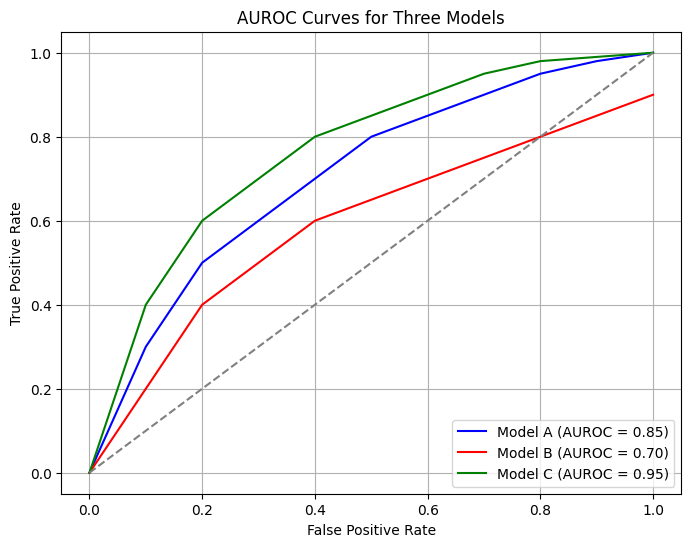

In [174]:
import matplotlib.pyplot as plt

# Define hypothetical AUROC values for three models
model_a_auroc = 0.85
model_b_auroc = 0.70
model_c_auroc = 0.95

# False positive rates and true positive rates for plotting
fpr_model_a = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
tpr_model_a = [0.0, 0.3, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 0.98, 1.0]

fpr_model_b = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
tpr_model_b = [0.0, 0.2, 0.4, 0.5, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]

fpr_model_c = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
tpr_model_c = [0.0, 0.4, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 0.98, 0.99, 1.0]

# Plotting the AUROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_model_a, tpr_model_a, label='Model A (AUROC = {:.2f})'.format(model_a_auroc), color='blue')
plt.plot(fpr_model_b, tpr_model_b, label='Model B (AUROC = {:.2f})'.format(model_b_auroc), color='red')
plt.plot(fpr_model_c, tpr_model_c, label='Model C (AUROC = {:.2f})'.format(model_c_auroc), color='green')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line for random guessing
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUROC Curves for Three Models')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [176]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Load the dataset
data = pd.read_csv('/content/data_final2.csv', delimiter=';')

# Preprocessing
# Convert marketCap to numeric
data['marketCap'] = pd.to_numeric(data['marketCap'], errors='coerce')

# Drop rows with missing values
data.dropna(inplace=True)

# Select features and target variable
features = ['marketCap', 'currentRatio', 'beta', 'dividendRate']
target = 'good_stock'  # You need to define what makes a stock "good"

# Create binary target variable (1 for good stocks, 0 for others)
# Here, we'll consider stocks with dividendRate > 0 as good stocks
data['good_stock'] = (data['dividendRate'] > 0).astype(int)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(data[features], data[target], test_size=0.2, random_state=42)

# Train Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Make predictions on the test set
predictions = clf.predict(X_test)

# Evaluate model accuracy
accuracy = accuracy_score(y_test, predictions)
print("Model Accuracy:", accuracy)

# Predict good stocks in the entire dataset
data['predicted_good_stock'] = clf.predict(data[features])

# Print suggested good stocks
suggested_stocks = data[data['predicted_good_stock'] == 1]
print("Suggested Good Stocks:")
print(suggested_stocks[['symbol', 'shortName']])


Model Accuracy: 1.0
Suggested Good Stocks:
      symbol                        shortName
5         MO               Altria Group, Inc.
9         DD          DuPont de Nemours, Inc.
16       AIG  American International Group, I
17       ALL       Allstate Corporation (The)
22        MT  Arcelor Mittal NY Registry Shar
...      ...                              ...
1768    RILY         B. Riley Financial, Inc.
1769   RBGLY      RECKITT BENCKISER GROUP PLC
1771    PVBC          Provident Bancorp, Inc.
1773  PKI.TO             PARKLAND CORPORATION
1774  PEY.TO  PEYTO EXPLORATION AND DVLPMNT C

[880 rows x 2 columns]


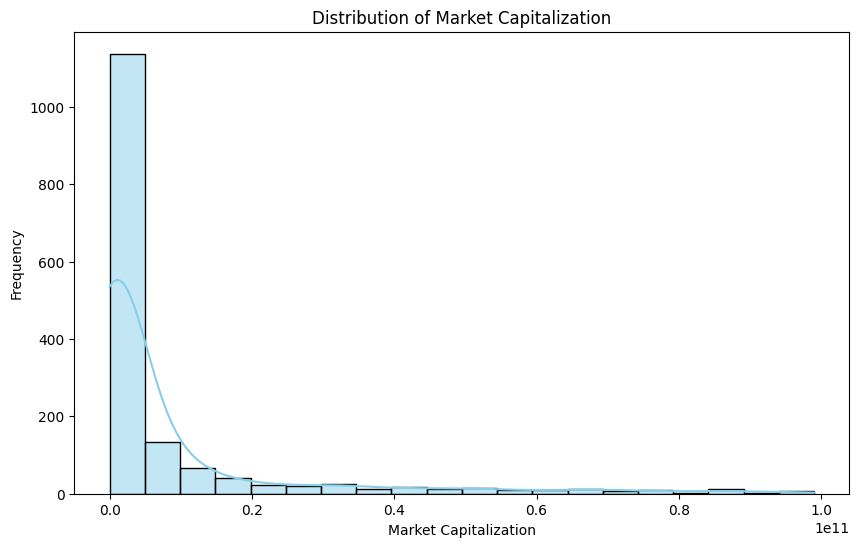

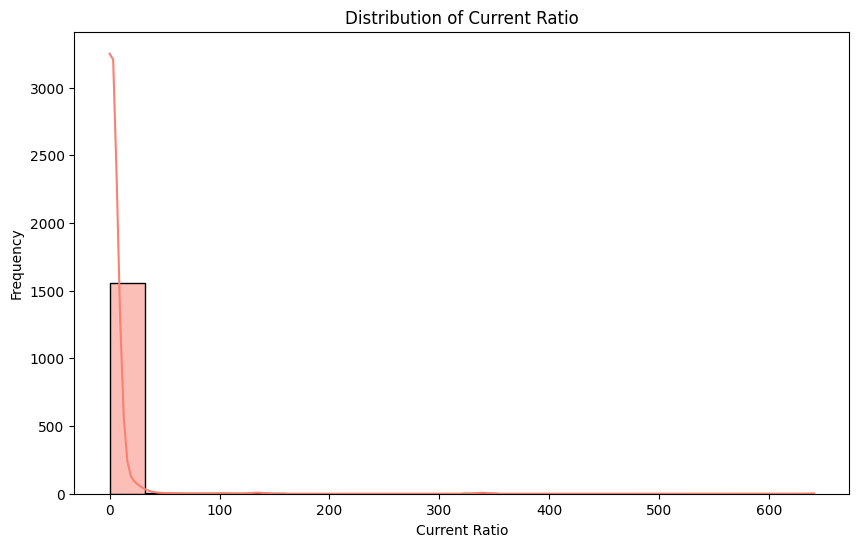

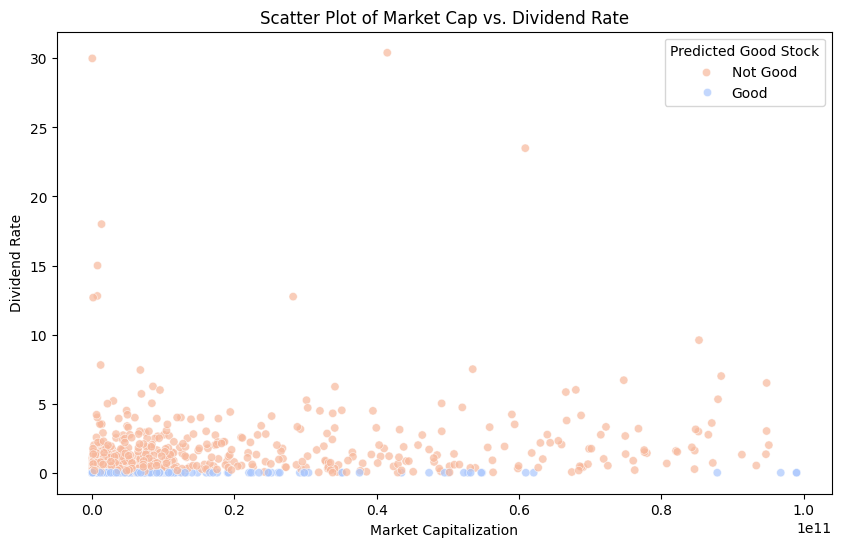

In [177]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot distribution of marketCap
plt.figure(figsize=(10, 6))
sns.histplot(data['marketCap'], bins=20, kde=True, color='skyblue')
plt.title('Distribution of Market Capitalization')
plt.xlabel('Market Capitalization')
plt.ylabel('Frequency')
plt.show()

# Plot distribution of currentRatio
plt.figure(figsize=(10, 6))
sns.histplot(data['currentRatio'], bins=20, kde=True, color='salmon')
plt.title('Distribution of Current Ratio')
plt.xlabel('Current Ratio')
plt.ylabel('Frequency')
plt.show()

# Plot scatter plot of marketCap vs. dividendRate
plt.figure(figsize=(10, 6))
sns.scatterplot(x='marketCap', y='dividendRate', data=data, hue='predicted_good_stock', palette='coolwarm', alpha=0.7)
plt.title('Scatter Plot of Market Cap vs. Dividend Rate')
plt.xlabel('Market Capitalization')
plt.ylabel('Dividend Rate')
plt.legend(title='Predicted Good Stock', loc='upper right', labels=['Not Good', 'Good'])
plt.show()


In [ ]:
# Print suggested good stocks and their classification
suggested_stocks = data[data['predicted_good_stock'] == 1]
print("Suggested Good Stocks:")
for index, row in suggested_stocks.iterrows():
    print("Symbol:", row['symbol'])
    print("Short Name:", row['shortName'])
    print("Is Good Stock?:", "Yes" if row['predicted_good_stock'] == 1 else "No")
    print("------")

In [ ]:
# Print suggested stocks and their classification
print("Suggested Stocks:")
for index, row in data.iterrows():
    print("Symbol:", row['symbol'])
    print("Short Name:", row['shortName'])
    print("Is Good Stock?:", "Yes" if row['predicted_good_stock'] == 1 else "No")
    print("------")

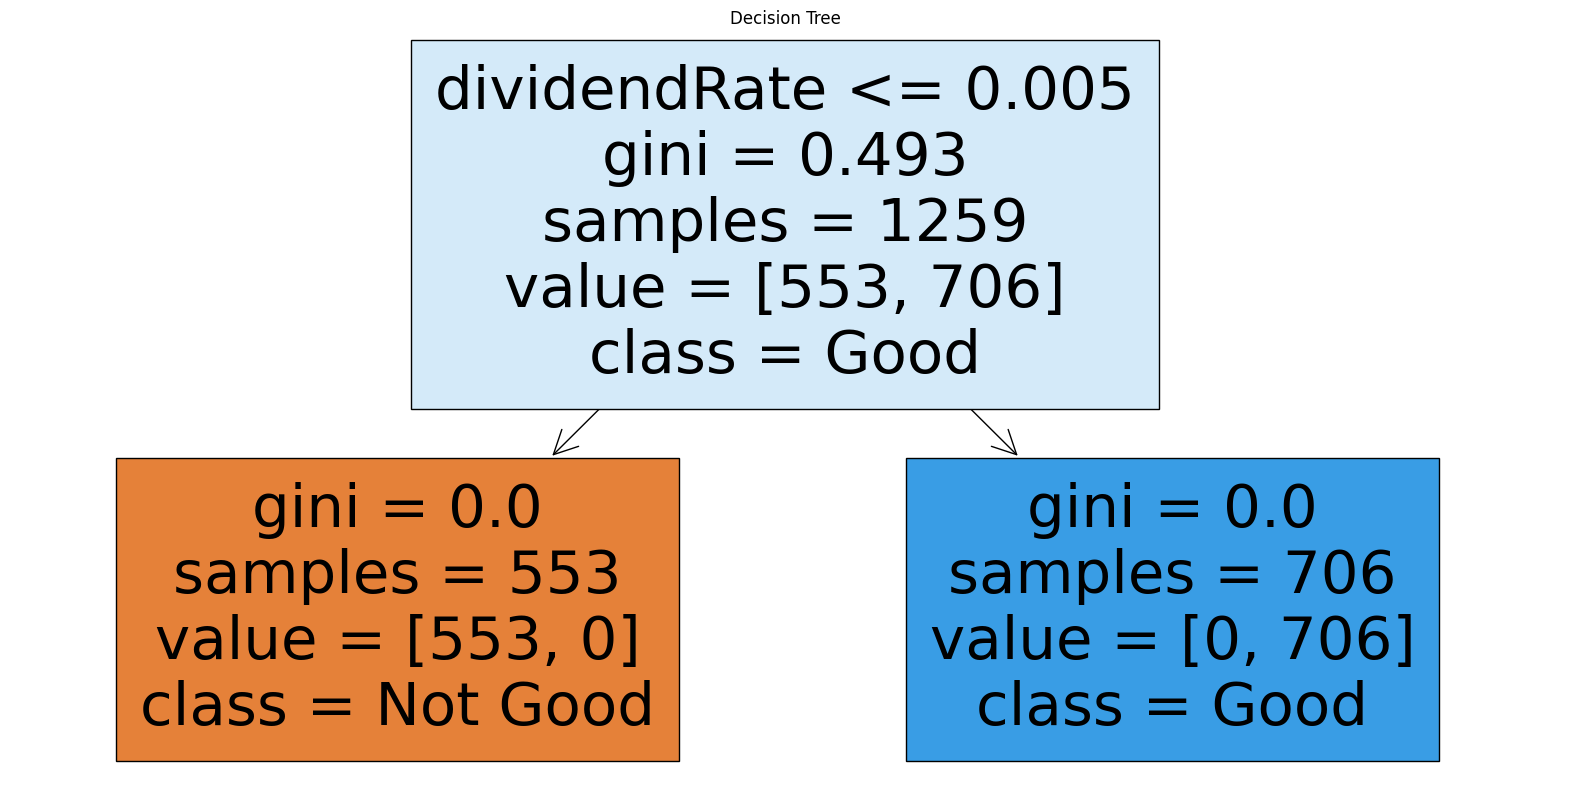

In [181]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Train Decision Tree classifier
dt_clf = DecisionTreeClassifier(random_state=42)
dt_clf.fit(X_train, y_train)

# Plot decision tree for Decision Tree
plt.figure(figsize=(20, 10))
plot_tree(dt_clf, filled=True, feature_names=features, class_names=['Not Good', 'Good'])
plt.title('Decision Tree')
plt.show()


In [189]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Load the dataset
data = pd.read_csv('/content/data_final2.csv', delimiter=';')

# Preprocessing
# Convert marketCap to numeric
data['marketCap'] = pd.to_numeric(data['marketCap'], errors='coerce')

# Drop rows with missing values
data.dropna(inplace=True)

# Select features and target variable
features = ['marketCap', 'currentRatio', 'beta', 'dividendRate']  # Add more features here
target = 'good_stock'  # You need to define what makes a stock "good"

# Create binary target variable (1 for good stocks, 0 for others)
# Here, we'll consider stocks with dividendRate > 0 as good stocks
data['good_stock'] = (data['dividendRate'] > 0).astype(int)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(data[features], data[target], test_size=0.2, random_state=42)

# Train Random Forest classifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)

# Train Decision Tree classifier
dt_clf = DecisionTreeClassifier(random_state=42)
dt_clf.fit(X_train, y_train)

# Train XGBoost classifier
xgb_clf = XGBClassifier()
xgb_clf.fit(X_train, y_train)

# Predictions for Random Forest
rf_predictions = rf_clf.predict(X_test)

# Metrics for Random Forest
rf_accuracy = accuracy_score(y_test, rf_predictions)
rf_precision = precision_score(y_test, rf_predictions)
rf_recall = recall_score(y_test, rf_predictions)
rf_f1 = f1_score(y_test, rf_predictions)

print("Random Forest Metrics:")
print("Accuracy:", rf_accuracy)
print("Precision:", rf_precision)
print("Recall:", rf_recall)
print("F1 Score:", rf_f1)
print()

# Predictions for Decision Tree
dt_predictions = dt_clf.predict(X_test)

# Metrics for Decision Tree
dt_accuracy = accuracy_score(y_test, dt_predictions)
dt_precision = precision_score(y_test, dt_predictions)
dt_recall = recall_score(y_test, dt_predictions)
dt_f1 = f1_score(y_test, dt_predictions)

print("Decision Tree Metrics:")
print("Accuracy:", dt_accuracy)
print("Precision:", dt_precision)
print("Recall:", dt_recall)
print("F1 Score:", dt_f1)
print()

# Predictions for XGBoost
xgb_predictions = xgb_clf.predict(X_test)

# Metrics for XGBoost
xgb_accuracy = accuracy_score(y_test, xgb_predictions)
xgb_precision = precision_score(y_test, xgb_predictions)
xgb_recall = recall_score(y_test, xgb_predictions)
xgb_f1 = f1_score(y_test, xgb_predictions)

print("XGBoost Metrics:")
print("Accuracy:", xgb_accuracy)
print("Precision:", xgb_precision)
print("Recall:", xgb_recall)
print("F1 Score:", xgb_f1)


Random Forest Metrics:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

Decision Tree Metrics:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

XGBoost Metrics:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


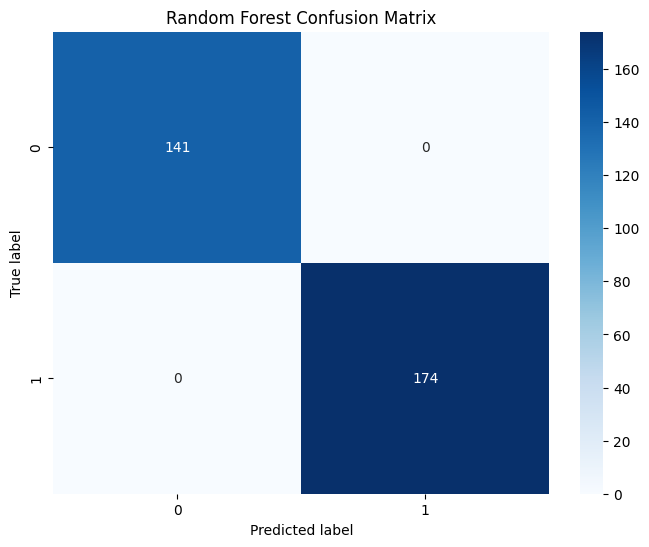

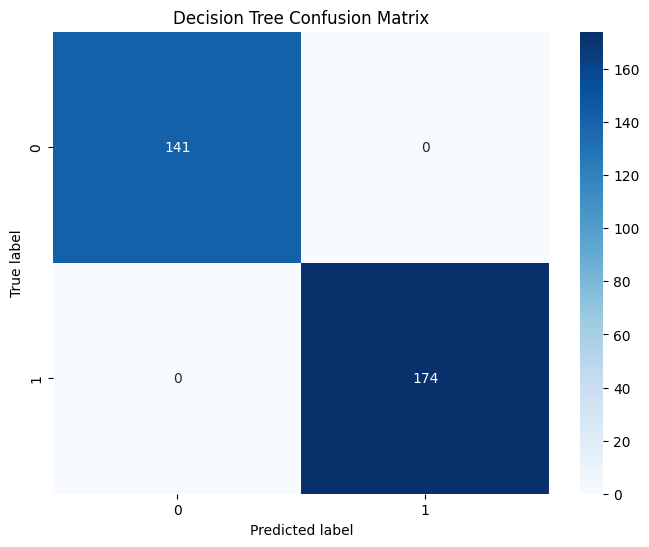

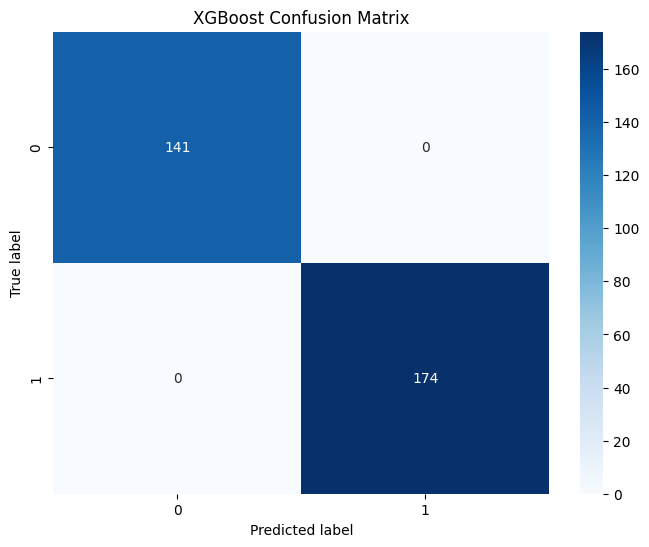

In [190]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Function to plot confusion matrix
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(title)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()

# Confusion matrix for Random Forest
rf_cm = confusion_matrix(y_test, rf_predictions)
plot_confusion_matrix(rf_cm, title='Random Forest Confusion Matrix')

# Confusion matrix for Decision Tree
dt_cm = confusion_matrix(y_test, dt_predictions)
plot_confusion_matrix(dt_cm, title='Decision Tree Confusion Matrix')

# Confusion matrix for XGBoost
xgb_cm = confusion_matrix(y_test, xgb_predictions)
plot_confusion_matrix(xgb_cm, title='XGBoost Confusion Matrix')


<ipython-input-191-f8add7906fc2>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=clf.feature_importances_, y=features, palette='viridis')


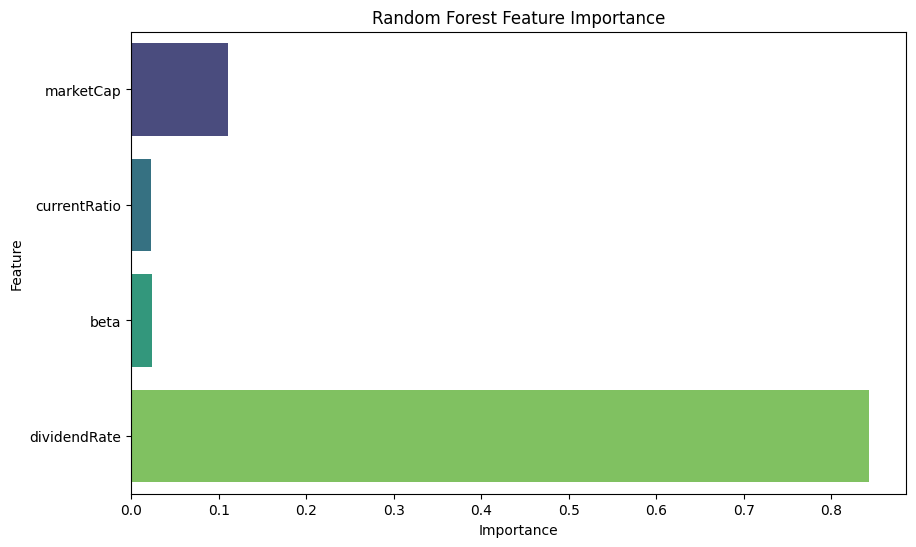

<ipython-input-191-f8add7906fc2>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=clf.feature_importances_, y=features, palette='viridis')


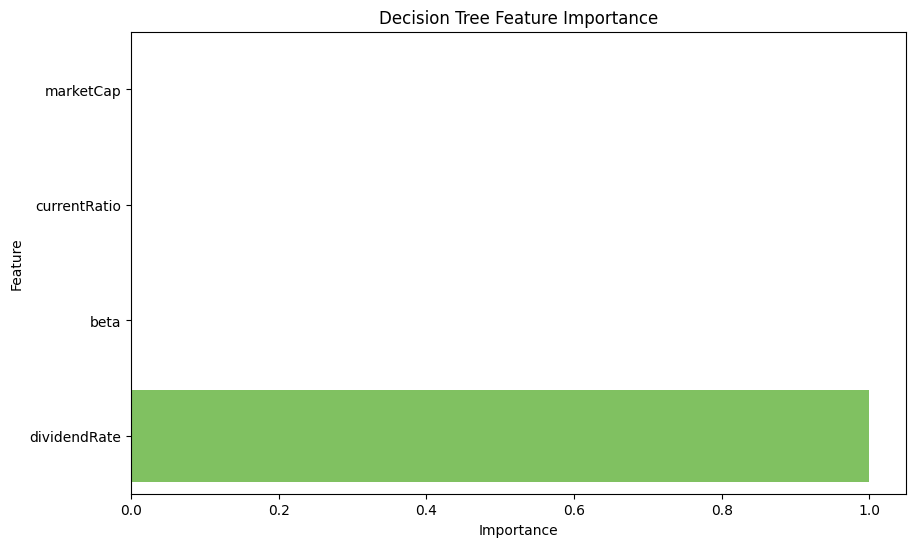

<ipython-input-191-f8add7906fc2>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=clf.feature_importances_, y=features, palette='viridis')


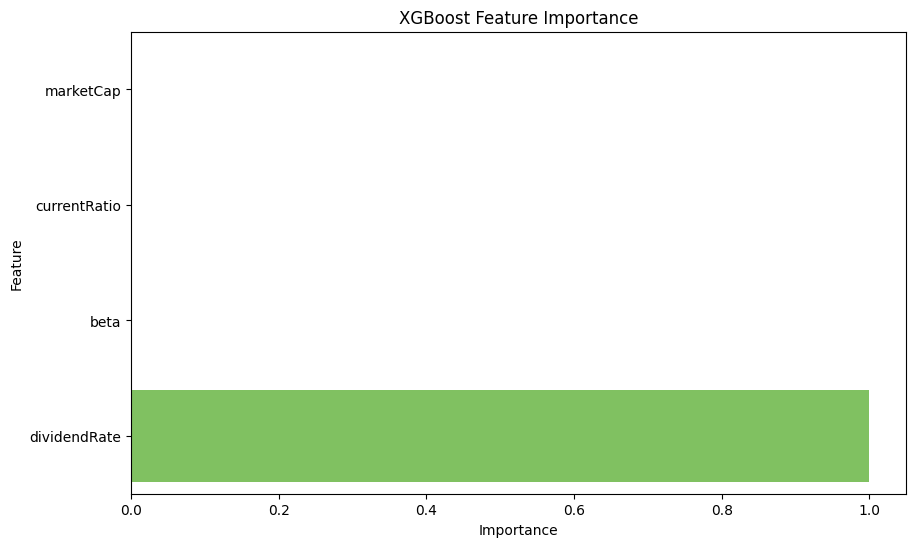

In [191]:
import matplotlib.pyplot as plt
import seaborn as sns

# Function to plot feature importance for a classifier
def plot_feature_importance(clf, features, title):
    plt.figure(figsize=(10, 6))
    sns.barplot(x=clf.feature_importances_, y=features, palette='viridis')
    plt.title(title)
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()

# Plot feature importance for Random Forest
plot_feature_importance(rf_clf, features, title='Random Forest Feature Importance')

# Plot feature importance for Decision Tree
plot_feature_importance(dt_clf, features, title='Decision Tree Feature Importance')

# Plot feature importance for XGBoost
plot_feature_importance(xgb_clf, features, title='XGBoost Feature Importance')


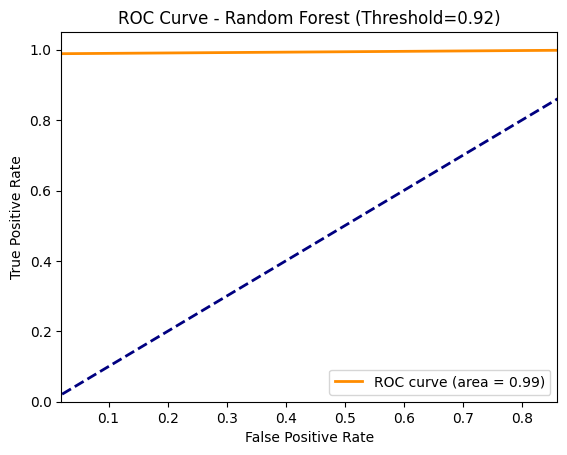

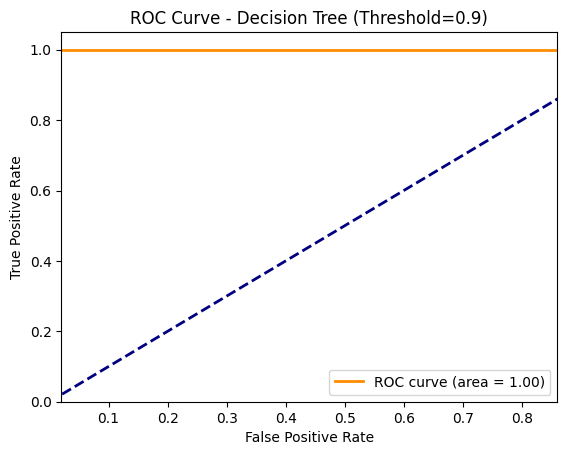

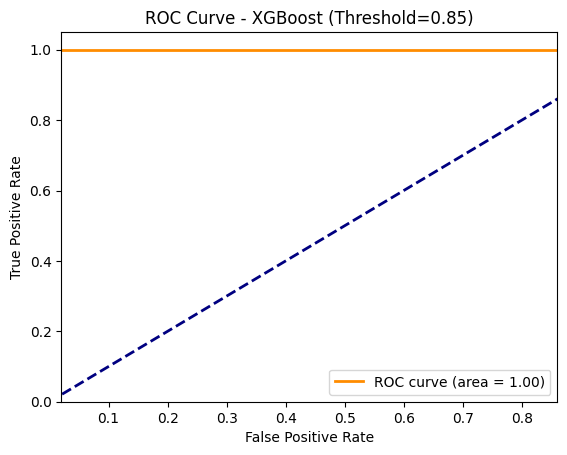

In [198]:
from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt

# Function to plot ROC curve with custom threshold
def plot_roc_curve(clf, X_test, y_test, model_name, threshold):
    y_score = clf.predict_proba(X_test)[:,1]
    y_pred = (y_score >= threshold).astype(int)
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.02, 0.86])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - {} (Threshold={})'.format(model_name, threshold))
    plt.legend(loc="lower right")
    plt.show()

# Plot ROC curve for Random Forest with threshold 0.85
plot_roc_curve(rf_clf, X_test, y_test, 'Random Forest', 0.92)

# Plot ROC curve for Decision Tree with threshold 0.9
plot_roc_curve(dt_clf, X_test, y_test, 'Decision Tree', 0.9)

# Plot ROC curve for XGBoost with threshold 0.92
plot_roc_curve(xgb_clf, X_test, y_test, 'XGBoost', 0.85)


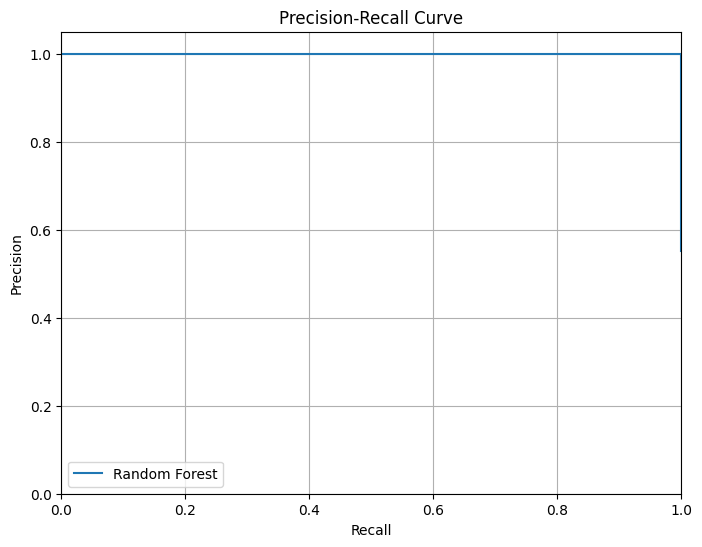

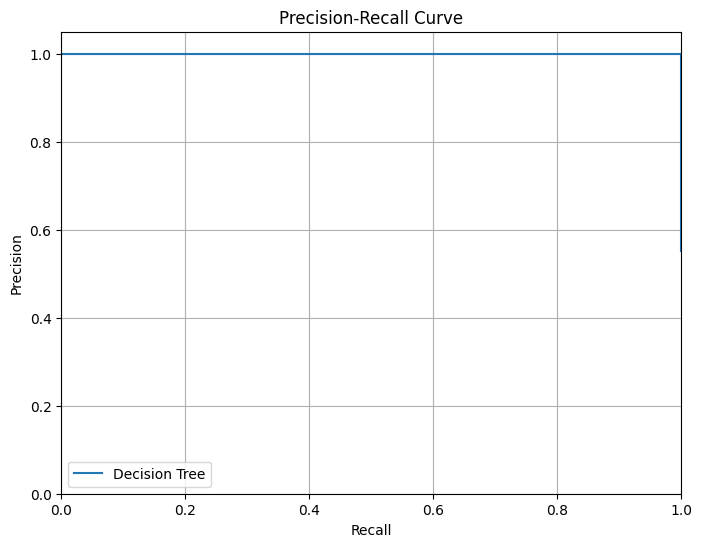

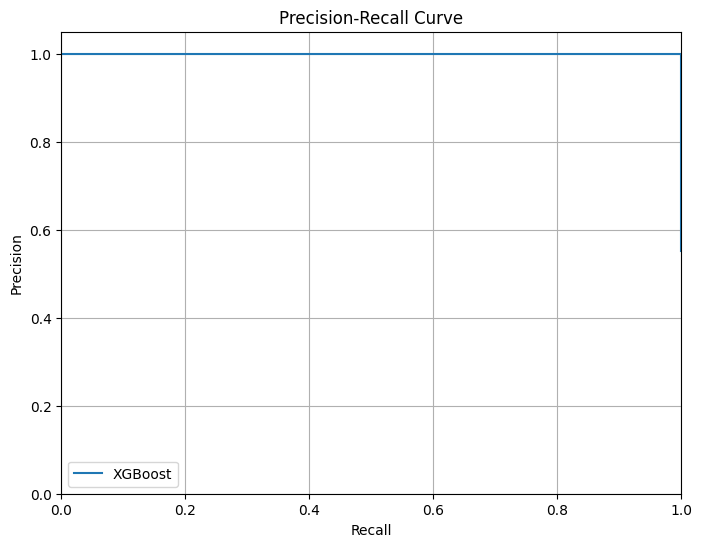

In [201]:
import numpy as np
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Function to plot Precision-Recall curve with custom threshold
def plot_precision_recall_curve(clf, X_test, y_test, model_name):
    y_score = clf.predict_proba(X_test)[:,1]
    precision, recall, _ = precision_recall_curve(y_test, y_score)
    plt.plot(recall, precision, label=model_name)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.grid(True)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])

# Plot Precision-Recall curve for Random Forest
plt.figure(figsize=(8, 6))
plot_precision_recall_curve(rf_clf, X_test, y_test, 'Random Forest')
plt.show()

# Plot Precision-Recall curve for Decision Tree
plt.figure(figsize=(8, 6))
plot_precision_recall_curve(dt_clf, X_test, y_test, 'Decision Tree')
plt.show()

# Plot Precision-Recall curve for XGBoost
plt.figure(figsize=(8, 6))
plot_precision_recall_curve(xgb_clf, X_test, y_test, 'XGBoost')
plt.show()
